# Illustrate committor active learning with AMS on the MB potential

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)

Using device: cuda


Imports for AMS and muller brown potential

In [3]:
from potentials.EntropicSwitchTrippleWellPotential import EntropicSwitchTrippleWellPotential
from simulations.AMSSimulation import AMSOverdampedLangevin

Import for committor learning

In [4]:
from committor.neural_net_models import CommittorTwoDecoder
from committor.train_committor import TainCommittorOverdampedTwoDecoder

Define potential and neural net for committor approximation and the corresponding training object 

In [5]:
pot = EntropicSwitchTrippleWellPotential()
pot.set_2D_plot_grid_precision(200, 200)
## Generate 100 penalization points on each boundary of R and P
theta = np.random.uniform(0,np.pi, size=[100])
pen_points = np.append(np.append(pot.minR + np.array([pot.R_radius * np.cos(theta), pot.R_radius * np.sin(theta)]).T, np.zeros([100, 1]), axis=1), np.append(pot.minP + np.array([pot.P_radius * np.cos(theta), pot.P_radius * np.sin(theta)]).T, np.ones([100, 1]), axis=1), axis=0)


#committor = torch.load('AMS_xi_comm_ES')
committor = CommittorTwoDecoder([2, 5, 5, 1], [1, 20, 20, 2], 0, pot)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

In [6]:
MEP_1 = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[0][i])
    i += 1
MEP_1 = np.array(MEP_1)
MEP_2 = [pot.minimum_energy_paths[1][0]]
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[1][i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[1][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[2]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[2][-i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[2][-i])
    i += 1
MEP_2 = np.array(MEP_2)

Define temperature via $\beta = \left( k_\mathrm{B} T \right)^{-1}$, time step size and AMS simulation object 

In [7]:
beta = 4
dt = 0.01
AMS_on_MB = AMSOverdampedLangevin(pot, xi=None, beta=beta, forward=True, dt=dt, threshold=10**(-8))

Run dynamics to sample intitial conditions in reactant and product metastable state

In [8]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(True)
print(n_steps_b + n_steps_f)

841


In [9]:
N = 1
ini_index = np.arange(0, len(ini_traj_f["x_traj"]) - N, N)
j = 0
if pot.in_P(ini_traj_f["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]]):
    x_beg = None
else:
    x_beg = ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1]
x_end = None
data = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])) and x_beg is not None:
    x_end = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
for i in range(1, N):
    if x_end is not None:
        data = np.append(data, np.zeros([1, 2]), axis=1)
        data = np.append(data, x_end, axis=1)
    else:
        data = np.append(data, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
            x_end = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
        elif not (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])):
            x_beg = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
for j in range(1, len(ini_index)):
    if pot.in_P(ini_traj_f["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]]):
        x_beg = None
    else:
        x_beg = ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1]
    x_end = None
    datapoint = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
    if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])) and x_beg is not None:
        x_end = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
                x_end = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
            elif not (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])):
                x_beg = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
    data = np.append(data, datapoint, axis=0)
ini_index = np.arange(0, len(ini_traj_b["x_traj"]) - N, N)   
for j in range(0, len(ini_index)):
    if pot.in_P(ini_traj_b["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]]):
        x_beg = None
    else:
        x_beg = ini_traj_b["x_traj"][ini_index[j]:ini_index[j]+1]
    x_end = None
    datapoint = np.append(ini_traj_b["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_b["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
    if (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1])) and x_beg is not None:
        x_end = ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, ini_traj_b["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            if (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
                x_end = ini_traj_b["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
            elif not (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1])):
                x_beg = ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2]
    data = np.append(data, datapoint, axis=0)   
print(data.shape)

dataset = {"any_distrib" : data, "beta" : beta, "dt" : dt}
dataset.keys()

(839, 6)


dict_keys(['any_distrib', 'beta', 'dt'])

   Define the committor training object, and prepare training

In [10]:
committor_training = TainCommittorOverdampedTwoDecoder(committor, pot, dataset)
committor_training.train_test_split(train_size= 8 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50

committor_training.set_loss_weight(loss_params)
batch_size = 100
max_epochs = 1000

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Train the committor model 

In [11]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 1000 epochs.



Plot results

/tmp/ipykernel_6603/2791166615.py:15: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_6603/2791166615.py:33: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


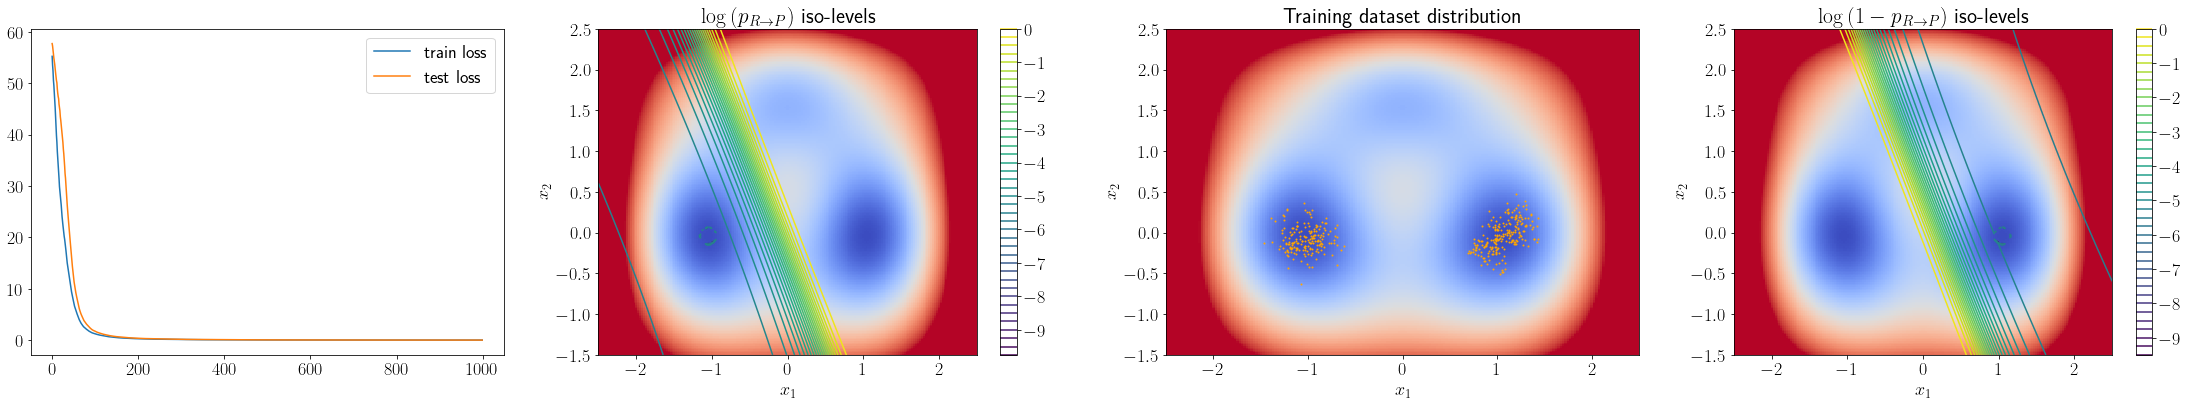

In [22]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(39, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title(r'$ \log \left( p_{R\rightarrow P} \right) $ iso-levels')
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_title(r'Training dataset distribution')

ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=1)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
#ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title(r'$ \log \left(1-p_{R\rightarrow P} \right) $ iso-levels')
plt.savefig("ES_itarative_AMS.png", format='png', dpi=160)

Run AMS forward

/tmp/ipykernel_6603/1197603746.py:6: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')


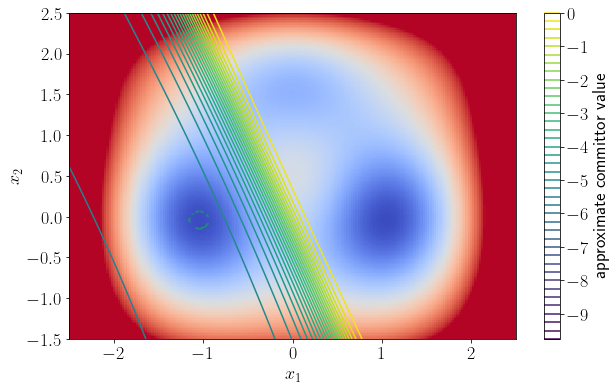

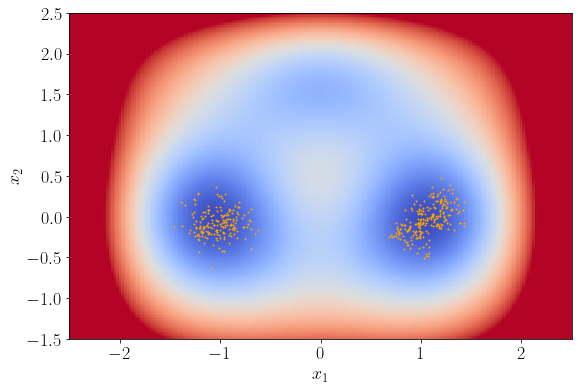

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6)) 
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='approximate committor value') 
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
plt.savefig('first_ES_training_a.png', format='png', dpi=160)

fig, (ax2) = plt.subplots(1, 1, figsize=(9, 6)) 
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=1)
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
plt.savefig('first_ES_training_b.png', format='png', dpi=160)

In [24]:
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(True)

In [25]:
print(p_f)
print(p_b)

2.154372182410666e-05
1.1024882343763105e-05


Add the new sampled trajectories to the dataset

In [26]:
#N = 10 ## Do not change the N if you want to add to the existing dataset because the time lagg has to be constant within the dataset. 
if N == 1:
    dataset_f = np.concatenate((replicas_f[0]["x_traj"][:-1, :], replicas_f[0]["gauss_traj"][1:, :], replicas_f[0]["x_traj"][1:, :]), axis=1)
else:
    dataset_f = np.concatenate((replicas_f[0]["x_traj"][:-N, :], replicas_f[0]["gauss_traj"][1:-N+1, :], replicas_f[0]["x_traj"][1:-N+1, :]), axis=1)
for i in range(1, N):
    if i + 1 == N:
        dataset_f = np.concatenate((dataset_f, replicas_f[0]["gauss_traj"][1+i:, :], replicas_f[0]["x_traj"][1+i:, :]), axis=1)
    else:
        dataset_f = np.concatenate((dataset_f, replicas_f[0]["gauss_traj"][1+i:-N+1+i, :], replicas_f[0]["x_traj"][1+i:-N+1+i, :]), axis=1)
data = dataset_f[-np.arange(0, len(replicas_f[0]["x_traj"])-N, N) -1].copy()
for j in range(1, len(replicas_f)):
    if N == 1:
        dataset_f = np.concatenate((replicas_f[j]["x_traj"][:-1, :], replicas_f[j]["gauss_traj"][1:, :], replicas_f[j]["x_traj"][1:, :]), axis=1)
    else:
        dataset_f = np.concatenate((replicas_f[j]["x_traj"][:-N, :], replicas_f[j]["gauss_traj"][1:-N+1, :], replicas_f[j]["x_traj"][1:-N+1, :]), axis=1)
    for i in range(1, N):
        if i + 1 == N:
            dataset_f = np.concatenate((dataset_f, replicas_f[j]["gauss_traj"][1+i:, :], replicas_f[j]["x_traj"][1+i:, :]), axis=1)
        else:
            dataset_f = np.concatenate((dataset_f, replicas_f[j]["gauss_traj"][1+i:-N+1+i, :], replicas_f[j]["x_traj"][1+i:-N+1+i, :]), axis=1)
    data = np.append(data, dataset_f[-np.arange(0, len(replicas_f[j]["x_traj"])-N, N) -1], axis=0)
for j in range(len(replicas_b)):    
    if N == 1:
        dataset_b = np.concatenate((replicas_b[j]["x_traj"][:-1, :], replicas_b[j]["gauss_traj"][1:, :], replicas_b[j]["x_traj"][1:, :]), axis=1)
    else:
        dataset_b = np.concatenate((replicas_b[j]["x_traj"][:-N, :], replicas_b[j]["gauss_traj"][1:-N+1, :], replicas_b[j]["x_traj"][1:-N+1, :]), axis=1)
    for i in range(1, N):
        if i + 1 == N:
            dataset_b = np.concatenate((dataset_b, replicas_b[j]["gauss_traj"][1+i:, :], replicas_b[j]["x_traj"][1+i:, :]), axis=1)
        else:
            dataset_b = np.concatenate((dataset_b, replicas_b[j]["gauss_traj"][1+i:-N+1+i, :], replicas_b[j]["x_traj"][1+i:-N+1+i, :]), axis=1)
    data = np.append(data, dataset_b[-np.arange(0, len(replicas_b[j]["x_traj"])-N, N) -1], axis=0)

## But you can start a new dataset and erase the previous one by uncommenting the newt line and comment the following one
#dataset["any_distrib"] = data
dataset["any_distrib"] = np.append(dataset["any_distrib"], data, axis=0)
print(dataset["any_distrib"].shape)

(53759, 6)


Re-set the training dataset and train again 

In [27]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size= 2 * 10**4)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 10**3
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 684 epochs.



Plot the results 

/tmp/ipykernel_6603/2282955282.py:12: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_6603/2282955282.py:26: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


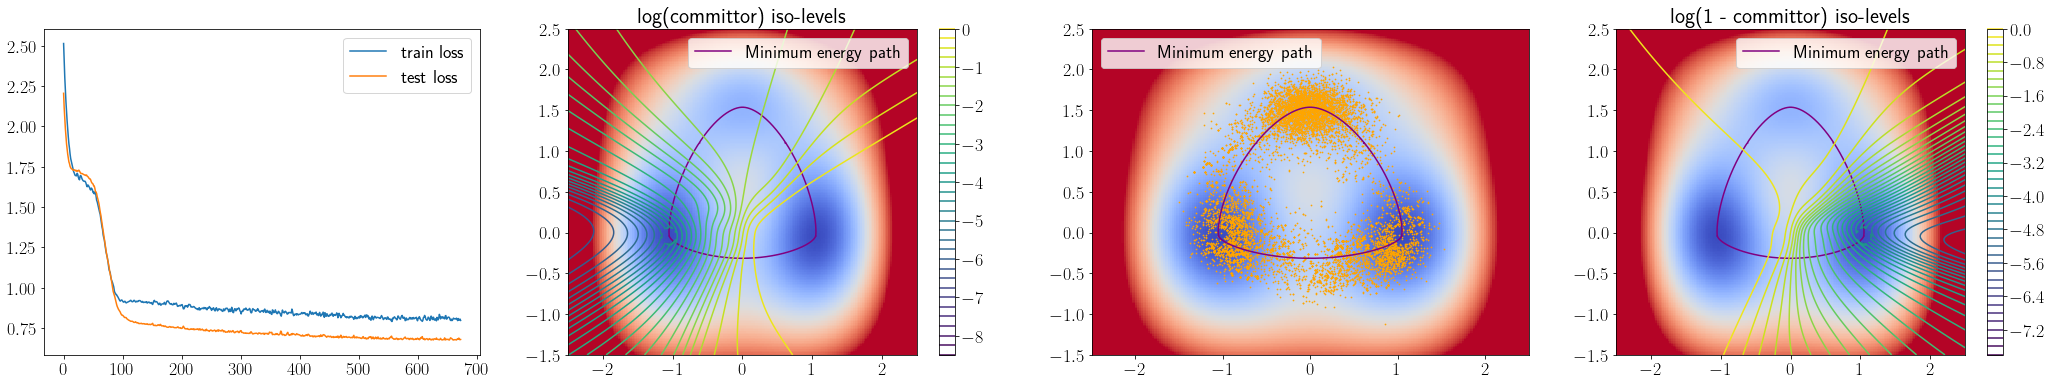

In [28]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][10:], label='train loss')
ax0.plot(loss_dict["test_loss"][10:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

/tmp/ipykernel_6603/1644765474.py:6: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')


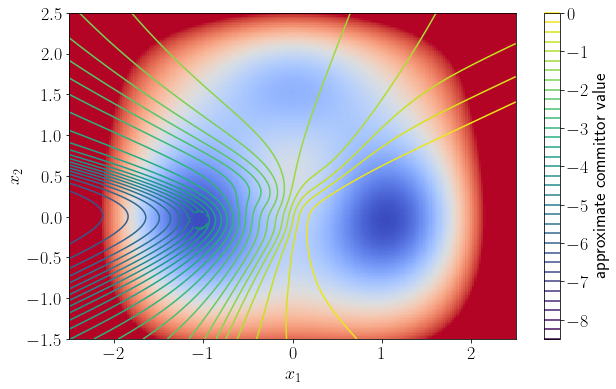

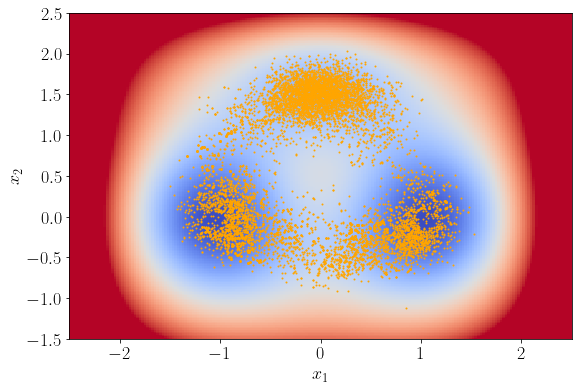

In [30]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6)) 
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='approximate committor value') 
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
plt.savefig('second_ES_training_a.png', format='png', dpi=160)

fig, (ax2) = plt.subplots(1, 1, figsize=(9, 6)) 
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=1)
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
plt.savefig('second_ES_training_b.png', format='png', dpi=160)

Test the quality with the reference from finite elements method.

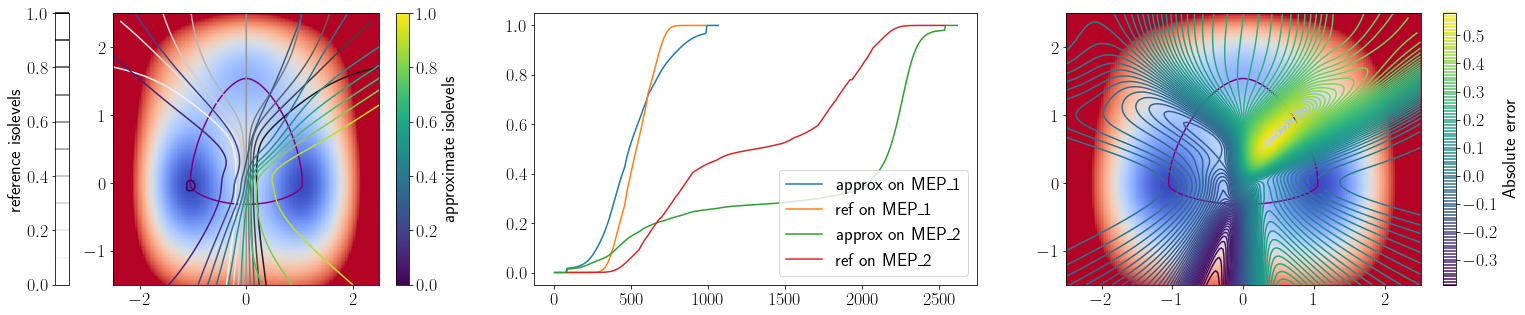

In [31]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(27, 5)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
#ax0.plot(err_MEP, label="error on MEP2")
ax0.legend()

In [32]:
# Compute RMSE on a sample of 1000 configurations distributed according ot the reactive trajectories measure. 
react = np.loadtxt('react_trajs_ES.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

RMSE react =  0.23411890688986636


## New iteration of the learning procedure. 

store the old values of the approximate committor 

In [96]:
app_committor_react_old = app_committor_react.copy()

Sample some new initial conditions 

In [97]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(True)
print(n_steps_b + n_steps_f)

800


Add to the dataset

In [98]:
N = 1 # Do not change the N if you want to add to the dataset because the time lagg has to be constant within the dataset. 
ini_index = np.arange(0, len(ini_traj_f["x_traj"])-N, N)
j = 0
if pot.in_P(ini_traj_f["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]]):
    x_beg = None
else:
    x_beg = ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1]
x_end = None
data = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])) and x_beg is not None:
    x_end = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
for i in range(1, N):
    if x_end is not None:
        data = np.append(data, np.zeros([1, 2]), axis=1)
        data = np.append(data, x_end, axis=1)
    else:
        data = np.append(data, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
            x_end = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
        elif not (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])):
            x_beg = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
for j in range(1, len(ini_index)):
    if pot.in_P(ini_traj_f["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]]):
        x_beg = None
    else:
        x_beg = ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1]
    x_end = None
    datapoint = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
    if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])) and x_beg is not None:
        x_end = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            if (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
                x_end = ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
            elif not (pot.in_P(ini_traj_f["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_f["x_traj"][ini_index[j]+1])):
                x_beg = ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2]
    data = np.append(data, datapoint, axis=0)
ini_index = np.arange(0, len(ini_traj_b["x_traj"])-N, N)   
for j in range(0, len(ini_index)):
    if pot.in_P(ini_traj_b["x_traj"][ini_index[j]]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]]):
        x_beg = None
    else:
        x_beg = ini_traj_b["x_traj"][ini_index[j]:ini_index[j]+1]
    x_end = None
    datapoint = np.append(ini_traj_b["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_b["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
    if (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1])) and x_beg is not None:
        x_end = ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, ini_traj_b["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            if (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1+i]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
                x_end = ini_traj_b["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
            elif not (pot.in_P(ini_traj_b["x_traj"][ini_index[j]+1]) or pot.in_R(ini_traj_b["x_traj"][ini_index[j]+1])):
                x_beg = ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2]
    data = np.append(data, datapoint, axis=0)    
print(data.shape)  
## But you can start a new dataset and erase the previous one by uncommenting the next line and comment the following 
#dataset = {"any_distrib" : data, "beta" : beta, "dt" : dt}
dataset["any_distrib"] = np.append(dataset["any_distrib"], data, axis=0)
print(dataset["any_distrib"].shape)

(798, 6)
(312041, 6)


In [99]:
N = 1 # Do not change the N if you want to add to the dataset because the time lagg has to be constant within the dataset. 
ini_index = np.arange(0, len(ini_traj_f["x_traj"])-N, N)
j = 0

data = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
for i in range(1, N):
    data = np.append(data, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
    data = np.append(data, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)

for j in range(1, len(ini_index)):
    datapoint = np.append(ini_traj_f["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_f["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 

    for i in range(1, N):
        datapoint = np.append(datapoint, ini_traj_f["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        datapoint = np.append(datapoint, ini_traj_f["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            
    data = np.append(data, datapoint, axis=0)
ini_index = np.arange(0, len(ini_traj_b["x_traj"])-N, N)   
for j in range(0, len(ini_index)):
    datapoint = np.append(ini_traj_b["x_traj"][ini_index[j]:ini_index[j]+1], ini_traj_b["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1) 
    for i in range(1, N):
        datapoint = np.append(datapoint, ini_traj_b["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        datapoint = np.append(datapoint, ini_traj_b["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            
    data = np.append(data, datapoint, axis=0)    
print(data.shape)  
## But you can start a new dataset and erase the previous one by uncommenting the next line and comment the following 
#dataset = {"any_distrib" : data, "beta" : beta, "dt" : dt}
dataset["any_distrib"] = np.append(dataset["any_distrib"], data, axis=0)
print(dataset["any_distrib"].shape)

(798, 6)
(312839, 6)


Run AMS again 

In [100]:
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(True)

In [101]:
print(p_f)
print(p_b)

9.104993135942223e-05
9.75320003007685e-06


Add sampled trajectories data to dataset 

In [102]:
##  N = 1 # Do not change the N if you want to add to the existing dataset because the time lagg has to be constant within the dataset. 
if N == 1:
    dataset_f = np.concatenate((replicas_f[0]["x_traj"][:-1, :], replicas_f[0]["gauss_traj"][1:, :], replicas_f[0]["x_traj"][1:, :]), axis=1)
else:
    dataset_f = np.concatenate((replicas_f[0]["x_traj"][:-N, :], replicas_f[0]["gauss_traj"][1:-N+1, :], replicas_f[0]["x_traj"][1:-N+1, :]), axis=1)
for i in range(1, N):
    if i + 1 == N:
        dataset_f = np.concatenate((dataset_f, replicas_f[0]["gauss_traj"][1+i:, :], replicas_f[0]["x_traj"][1+i:, :]), axis=1)
    else:
        dataset_f = np.concatenate((dataset_f, replicas_f[0]["gauss_traj"][1+i:-N+1+i, :], replicas_f[0]["x_traj"][1+i:-N+1+i, :]), axis=1)
data = dataset_f[-np.arange(0, len(replicas_f[0]["x_traj"])-N, N) -1].copy()
for j in range(1, len(replicas_f)):
    if N == 1:
        dataset_f = np.concatenate((replicas_f[j]["x_traj"][:-1, :], replicas_f[j]["gauss_traj"][1:, :], replicas_f[j]["x_traj"][1:, :]), axis=1)
    else:
        dataset_f = np.concatenate((replicas_f[j]["x_traj"][:-N, :], replicas_f[j]["gauss_traj"][1:-N+1, :], replicas_f[j]["x_traj"][1:-N+1, :]), axis=1)
    for i in range(1, N):
        if i + 1 == N:
            dataset_f = np.concatenate((dataset_f, replicas_f[j]["gauss_traj"][1+i:, :], replicas_f[j]["x_traj"][1+i:, :]), axis=1)
        else:
            dataset_f = np.concatenate((dataset_f, replicas_f[j]["gauss_traj"][1+i:-N+1+i, :], replicas_f[j]["x_traj"][1+i:-N+1+i, :]), axis=1)
    data = np.append(data, dataset_f[-np.arange(0, len(replicas_f[j]["x_traj"])-N, N) -1], axis=0)
for j in range(len(replicas_b)):    
    if N == 1:
        dataset_b = np.concatenate((replicas_b[j]["x_traj"][:-1, :], replicas_b[j]["gauss_traj"][1:, :], replicas_b[j]["x_traj"][1:, :]), axis=1)
    else:
        dataset_b = np.concatenate((replicas_b[j]["x_traj"][:-N, :], replicas_b[j]["gauss_traj"][1:-N+1, :], replicas_b[j]["x_traj"][1:-N+1, :]), axis=1)
    for i in range(1, N):
        if i + 1 == N:
            dataset_b = np.concatenate((dataset_b, replicas_b[j]["gauss_traj"][1+i:, :], replicas_b[j]["x_traj"][1+i:, :]), axis=1)
        else:
            dataset_b = np.concatenate((dataset_b, replicas_b[j]["gauss_traj"][1+i:-N+1+i, :], replicas_b[j]["x_traj"][1+i:-N+1+i, :]), axis=1)
    data = np.append(data, dataset_b[-np.arange(0, len(replicas_b[j]["x_traj"])-N, N) -1], axis=0)

## But you can start a new dataset and erase the previous one by uncommenting the newt line and comment the following one
#dataset["any_distrib"] = data
dataset["any_distrib"] = np.append(dataset["any_distrib"], data, axis=0)
print(dataset["any_distrib"].shape)

(382518, 6)


In [103]:
del(committor) ## In case you want to restart from here at a certain point
del(committor_training)
committor = CommittorTwoDecoder([2, 5, 5, 1], [1, 20, 20, 2], 0, pot)
committor_training = TainCommittorOverdampedTwoDecoder(committor, pot, dataset)
committor_training.set_optimizer('Adam', 0.005, parameters_to_train="decoders")
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["mse_react_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 100
committor_training.set_loss_weight(loss_params)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Re-train

In [104]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size=2 * 10**4)
committor_training.split_training_dataset_K_folds(4)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 1 * 10**3
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 1470 epochs.



/tmp/ipykernel_6603/3781039648.py:13: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_6603/3781039648.py:27: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


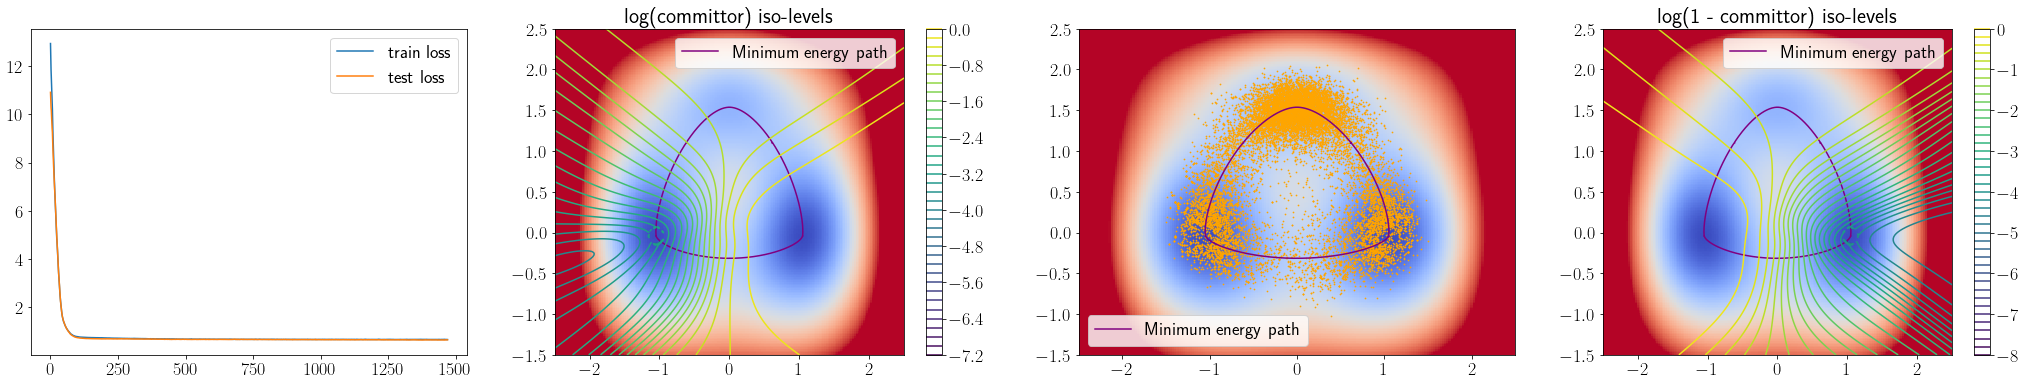

In [105]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()

contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

Plot figures to compare to the finite element reference

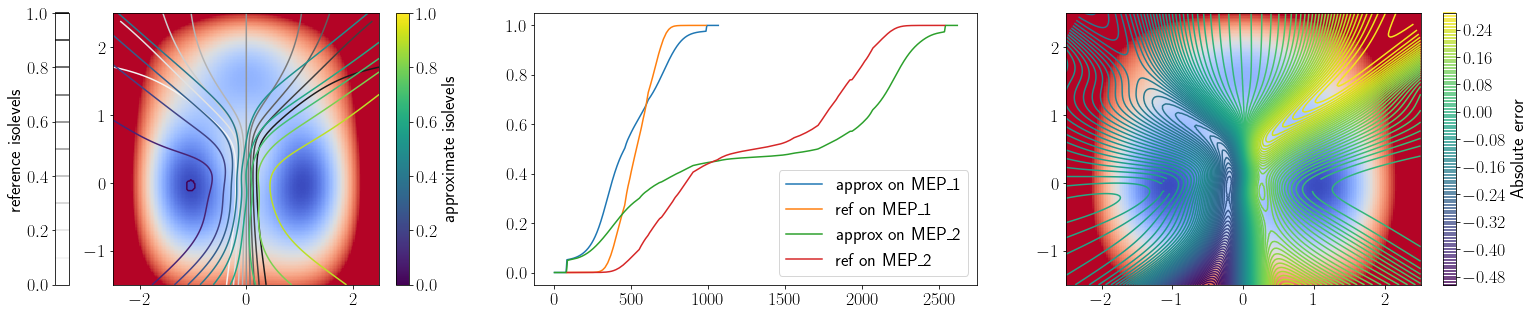

In [106]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(27, 5)) 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.  

In [107]:
react = np.loadtxt('react_trajs_ES.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)


RMSE react =  0.08598032896003141


In [108]:
from sklearn.metrics import r2_score

x = app_committor_react
y = app_committor_react_old
A = np.vstack([x, np.ones(len(x))]).T

coefs, r, rank ,s = np.linalg.lstsq(A, y, rcond=None)
print("Regression score = ", r2_score(app_committor_react, app_committor_react_old))

Regression score =  0.9514807724232678


In [109]:
n_conditions = 300
n_rep = 300
k_min = 1
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_MB.set_forward(True)

In [110]:
## Box to gather all the structures within reactive trajectories.
react_trajs = replicas_b[-n_rep]["x_traj"]
for i in range(1, n_rep):
    react_trajs = np.append(react_trajs, replicas_b[-i]["x_traj"], axis=0)
for i in range(len(replicas_f)):
    react_trajs = np.append(react_trajs, replicas_f[-i]["x_traj"], axis=0)    
print(react_trajs.shape)

(195761, 2)


In [111]:
ds  = {"any_distrib" : dataset["any_distrib"][:len(react_trajs), :], "react_points":react_trajs, "boltz_points":react_trajs, "beta" : beta, "dt" : dt}

In [112]:
#del(committor) ## In case you want to restart from here at a certain point
del(committor_training)
#committor = CommittorTwoDecoder([2, 5, 5, 1], [1, 20, 20, 2], 0, pot)
committor_training = TainCommittorOverdampedTwoDecoder(committor, pot, ds)
committor_training.set_optimizer('Adam', 0.005, parameters_to_train="decoders")
loss_params = {}
loss_params["ito_loss_weight"] = 0.0
loss_params["pen_points_weight"] = 0.0 * 10**(0)
loss_params["mse_react_weight"] = 1.0 * 10**(0)
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


In [113]:
committor_training.train_test_split(train_size=2 * 10**4)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
batch_size = 1 * 10**3
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 162 epochs.



/tmp/ipykernel_6603/3781039648.py:13: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_6603/3781039648.py:27: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


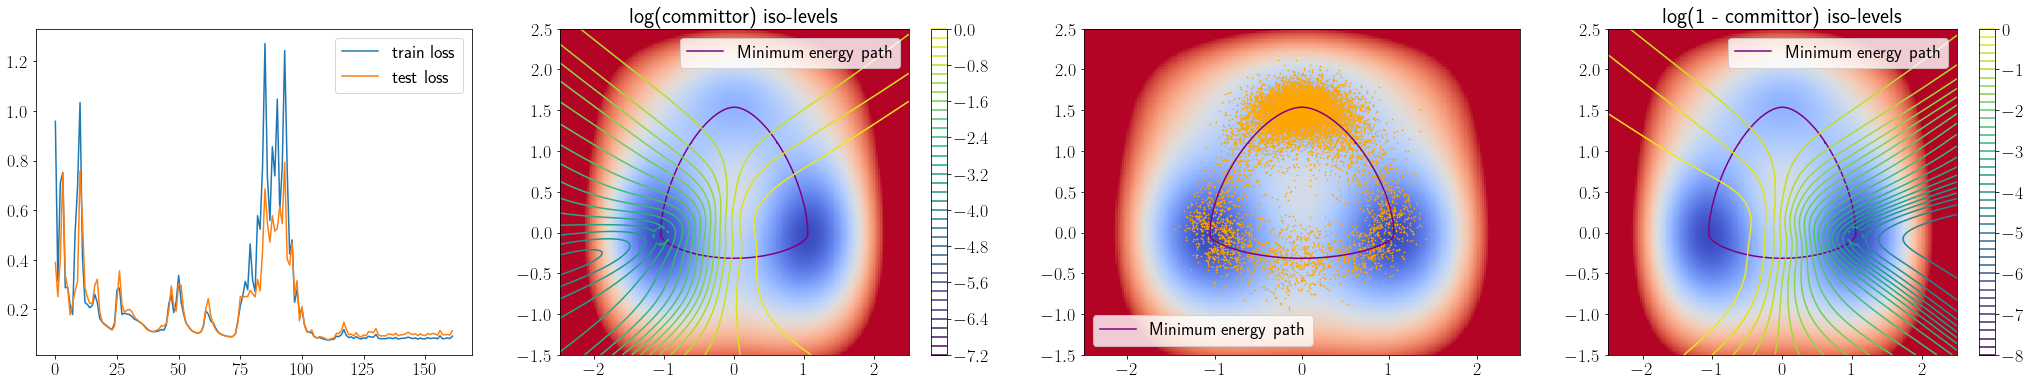

In [114]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(36, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()

contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

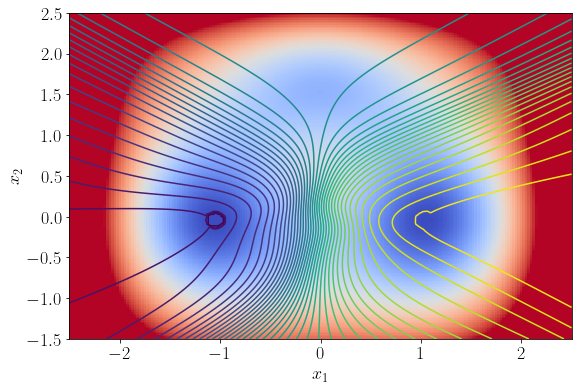

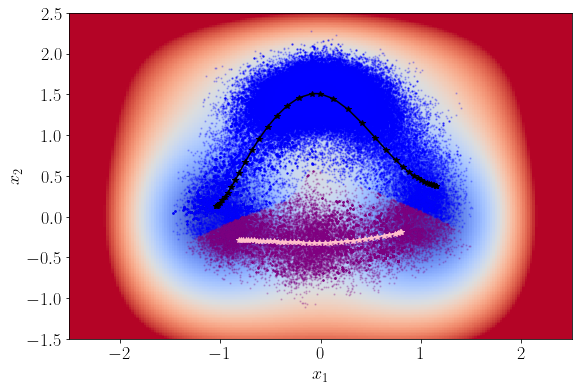

In [123]:
react_points = torch.tensor(committor_training.dataset["react_points"].astype('float32'))
react_points_decoded1 = committor_training.committor_model.decoder1(committor_training.committor_model.encoder(react_points))
react_points_decoded2 = committor_training.committor_model.decoder2(committor_training.committor_model.encoder(react_points))
x1 = torch.sum((react_points - react_points_decoded1) ** 2, dim=1).detach().numpy() < torch.sum(
            (react_points - react_points_decoded2) ** 2,
            dim=1).detach().numpy()
x2 = torch.sum((react_points - react_points_decoded2) ** 2, dim=1).detach().numpy() < torch.sum(
            (react_points - react_points_decoded1) ** 2,
            dim=1).detach().numpy()

xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([200, 200])

fig, (ax0) = plt.subplots(1, 1, figsize=(9, 6)) 
pot.plot_potential_heat_map(ax0)
#ax0.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax0.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax0.set_xlabel(r'$x_1$')
ax0.set_ylabel(r'$x_2$')
#ax0.legend()
committor_training.plot_committor_iso_levels(ax0, 40, set_lim=False)
plt.savefig('ES_AMS_result_clust_a.png', format='png', dpi=160)


fig, (ax1) = plt.subplots(1, 1, figsize=(9, 6)) 
pot.plot_potential_heat_map(ax1)
ax1.scatter(committor_training.dataset["react_points"][x1][:, 0], committor_training.dataset["react_points"][x1][:, 1], color='blue', s=1.5, alpha=0.2)
ax1.scatter(committor_training.dataset["react_points"][x2][:, 0], committor_training.dataset["react_points"][x2][:, 1], color='purple',s=1.5, alpha=0.2)
#ax1.plot(MEP_1[:, 0], MEP_1[:, 1], color='orange', label='Minimum energy path')
#ax1.plot(MEP_2[:, 0], MEP_2[:, 1], color='orange')
#committor_training.plot_conditional_averages(ax1, 40)
#committor_training.plot_committor_iso_levels(ax1, 40, set_lim=False)
#ax1.plot(Esp_X_given_z1[:, 0], Esp_X_given_z1[:, 1], '-o', color='midnightblue', label='cond. avg. decoder 1')
#ax1.plot(Esp_X_given_z2[:, 0], Esp_X_given_z2[:, 1], '-o', color='brown', label='cond. avg. decoder 2')
ax1.plot(f_dec_z1[:, 0], f_dec_z1[:, 1], '-*', color='black', label='decoder 1')
ax1.plot(f_dec_z2[:, 0], f_dec_z2[:, 1], '-*', color='pink', label='decoder 2')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
#ax1.legend()
plt.savefig('ES_AMS_result_clust_b.png', format='png', dpi=160)

#ax1.legend()

In [122]:
X_given_z1 = [[] for i in range(40)]
X_given_z2 = [[] for i in range(40)]
Esp_X_given_z1 = []
Esp_X_given_z2 = []
f_dec_z1 = []
f_dec_z2 = []
boltz_points = torch.tensor(committor_training.dataset["boltz_points"].astype('float32'))
boltz_points_decoded1 = committor_training.committor_model.decoder1(committor_training.committor_model.encoder(boltz_points))
boltz_points_decoded2 = committor_training.committor_model.decoder2(committor_training.committor_model.encoder(boltz_points))
xi_values = committor_training.committor_model.xi_forward(committor_training.dataset["boltz_points"])[:, :2]
z_bin = np.linspace(xi_values.min(), xi_values.max(), 40)
inds = np.digitize(xi_values, z_bin)
x1 = torch.sum((boltz_points - boltz_points_decoded1) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded2) ** 2,
            dim=1).detach().numpy()
x2 = torch.sum((boltz_points - boltz_points_decoded2) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded1) ** 2,
            dim=1).detach().numpy()
for bin_idx in range(40):
    X_given_z1[bin_idx] = boltz_points[x1 * (inds == bin_idx + 1)[:,0], :2]
    X_given_z2[bin_idx] = boltz_points[x2 * (inds == bin_idx + 1)[:,0], :2]
    if len(X_given_z1[bin_idx]) > 0:
        Esp_X_given_z1.append(X_given_z1[bin_idx].mean(dim=0))
        f_dec_z1.append(committor_training.committor_model.decoder1(committor_training.committor_model.encoder(Esp_X_given_z1[-1])).detach().numpy())
        Esp_X_given_z1[-1] = Esp_X_given_z1[-1].detach().numpy()
    if len(X_given_z2[bin_idx]) > 0:
        Esp_X_given_z2.append(X_given_z2[bin_idx].mean(dim=0))
        f_dec_z2.append(committor_training.committor_model.decoder2(committor_training.committor_model.encoder(Esp_X_given_z2[-1])).detach().numpy())
        Esp_X_given_z2[-1] = Esp_X_given_z2[-1].detach().numpy()
if committor_training.standardize:
    Esp_X_given_z1 = self.scaler.inverse_transform(np.array(Esp_X_given_z1))
    f_dec_z1 = self.scaler.inverse_transform(np.array(f_dec_z1))
    Esp_X_given_z2 = self.scaler.inverse_transform(np.array(Esp_X_given_z2))
    f_dec_z2 = self.scaler.inverse_transform(np.array(f_dec_z2))
elif committor_training.zca_whiten:
    Esp_X_given_z1 = np.linalg.inv(self.ZCAMatrix).dot(np.array(Esp_X_given_z1).T).T
    f_dec_z1 = np.linalg.inv(self.ZCAMatrix).dot(np.array(f_dec_z1).T).T
    Esp_X_given_z2 = np.linalg.inv(self.ZCAMatrix).dot(np.array(Esp_X_given_z2).T).T
    f_dec_z2 = np.linalg.inv(self.ZCAMatrix).dot(np.array(f_dec_z2).T).T
else:
    Esp_X_given_z1 = np.array(Esp_X_given_z1)
    f_dec_z1 = np.array(f_dec_z1)
    Esp_X_given_z2 = np.array(Esp_X_given_z2)
    f_dec_z2 = np.array(f_dec_z2)

In [ ]:
## Box to save a sub-sample of reactive trajectories sampled by AMS
size = 1 * 10**3

indices = np.random.choice(len(react_trajs), size=size)
react = react_trajs[indices][:, :2]

fig, (ax0) = plt.subplots(1, 1, figsize=(6, 4)) 
pot.plot_potential_heat_map(ax0)
ax0.plot(MEP_1[:, 0], MEP_1[:, 1], color='purple', label='Minimum energy path')
ax0.plot(MEP_2[:, 0], MEP_2[:, 1], color='purple')
ax0.scatter(react[:, 0], react[:, 1], color='orange', s=0.5)
print(react.shape)

In [ ]:
np.savetxt('react_trajs_ES.txt', react)
#np.savetxt('ES_react_dens.txt', react)

In [124]:
def xi_x_forward(x):
    return x[:, 0]

def xi_x_backward(x):
    return 1 - x[:, 0]

In [125]:
pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ES_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

def xi_comm_fem_forward(x):
    return interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

def xi_comm_fem_backward(x):
    return 1 - interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

In [126]:
m_real = 200
n_conditions = 100
n_rep = 100
k_min = 1
AMS_on_MB.set_xi(xi_x_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(xi_x_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)

print("""with x""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

with x
var forward :  7.793038771471453e-10
mean forward :  1.8369722603107094e-05
std forward :  2.79160147074604e-05
var backward :  7.467567342974717e-10
mean backward :  1.9212142933938145e-05
std backward :  2.7326850061751935e-05


In [ ]:
m_real = 200
n_conditions = 100
n_rep = 100
k_min = 1
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)

print("""with approx committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
AMS_on_MB.set_xi(xi_comm_fem_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
    p_forward.append(p_f)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(xi_comm_fem_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
    p_backward.append(p_b)
AMS_on_MB.set_forward(True)


print("""with fem committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
torch.save(committor_training.committor_model, "AMS_xi_comm_ES")